Hello this is the project workbook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


<function matplotlib.pyplot.show(close=None, block=None)>

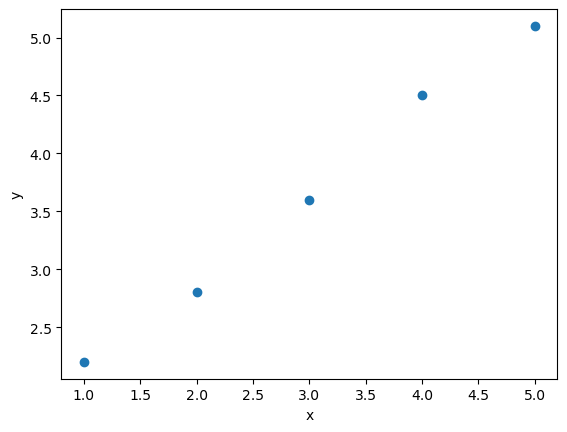

In [2]:
x=np.array([1,2,3,4,5])
y=np.array([2.2,2.8,3.6,4.5,5.1])



plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')     
plt.show

26.9.25

Ok so I got everything working on new laptop

Had a look at BNL NNDC isotope chart and beginng to look in to exfor database and some of the literature


consutling https://www-nds.iaea.org/nrdc/basics/exfor-basics-1.html

found this https://www-nds.iaea.org/exfor/x4stat/exfor_stat.htm

and this https://github.com/afedynitch/x4i3/tree/master

file:///Users/glsw/Downloads/x4i.pdf

In [3]:
import json as json
import requests
import x4i3 as x4i3
import time

Using database version x4i3_X4-2023-04-29 located in: /opt/anaconda3/envs/env1/lib/python3.11/site-packages/x4i3/data


In [4]:
from x4i3 import exfor_manager, exfor_entry

In [7]:
def calculate_total_datapoints(isotope, quantity='SIG'):
    """
    Queries the EXFOR database for a specific isotope and quantity,
    then retrieves the parsed data and counts the total number of data points.
    (Final corrected version)
    """
    total_datapoints = 0
    
    try:
        db = exfor_manager.X4DBManagerDefault()
        print("Database manager initialized successfully.")
    except Exception as e:
        print(f"Failed to initialize database manager: {e}")
        print("Please ensure you have run the setupEXFORdb.py script first.")
        return None

    print(f"Querying for target='{isotope}' and quantity='{quantity}'...")
    query_results = db.query(target=isotope, quantity=quantity)
    
    if not query_results:
        print("No entries found matching the criteria.")
        return 0
        
    entry_ids = list(query_results.keys())
    print(f"Found {len(entry_ids)} matching entries. Now processing data...")

    for entry_id in entry_ids:
        try:
            # --- FIX IS HERE ---
            # db.retrieve() returns a dictionary containing the ALREADY PARSED entry object.
            # We do not need to parse it again.
            retrieved_data = db.retrieve(ENTRY=entry_id)
            parsed_entry = retrieved_data[entry_id] # This is the X4Entry object we need.
            
            # Now we can use the object directly.
            simplified_datasets = parsed_entry.getSimplifiedDataSets()
            
            for dataset in simplified_datasets.values():
                num_rows = len(dataset.data)
                total_datapoints += num_rows
                
        except Exception as e:
            print(f"Could not process entry {entry_id}: {e}")
            
    return total_datapoints

In [ ]:
# --- Configuration and Execution ---

isotope_to_find = "U-235"
total_points = calculate_total_datapoints(isotope_to_find)

if total_points is not None:
    print("\n--- Analysis Complete ---")
    print(f"Found a total of {total_points} cross section data points for {isotope_to_find}.")

Database manager initialized successfully.
Querying for target='U-235' and quantity='SIG'...
Found 579 matching entries. Now processing data...


In [ ]:
import os
import re
import pprint
from x4i3 import exfor_manager, exfor_entry

# --- Configuration ---
# Set this path to the root of your EXFOR database (the 'entry' folder)
db_root_path = '/Users/glsw/python/entry/'

# Set the environment variable so the x4i3 library can find the database
os.environ['X4I_DB_ROOT'] = db_root_path

In [ ]:
def discover_all_isotopes(directory):
    """
    Scans the entire local EXFOR database to find all unique target isotopes.
    """
    print("Starting Phase 1: Discovering all unique isotopes in the database...")
    unique_isotopes = set()
    db_manager = exfor_manager.X4DBManagerDefault()
    
    # Regex to find patterns like '92-U-235' in reaction strings
    isotope_pattern = re.compile(r'\((\d{1,3}-[A-Z]{1,3}-\d{1,3})')

    all_files = [os.path.join(root, filename) for root, _, files in os.walk(directory) for filename in files]
    print(f"Found {len(all_files)} files to scan...")

    for i, file_path in enumerate(all_files):
        if (i + 1) % 1000 == 0:
            print(f"  ...scanned {i+1}/{len(all_files)} files...")
        try:
            entry_id = os.path.splitext(os.path.basename(file_path))[0]
            retrieved_data = db_manager.retrieve(ENTRY=entry_id)
            parsed_entry = retrieved_data[entry_id]
            
            for subentry_data in parsed_entry.values():
                if "REACTION" in subentry_data:
                    reaction_string = str(subentry_data["REACTION"])
                    match = isotope_pattern.search(reaction_string)
                    if match:
                        unique_isotopes.add(match.group(1))
        except Exception:
            continue
            
    print(f"Discovery complete. Found {len(unique_isotopes)} unique isotopes.")
    return sorted(list(unique_isotopes))

In [ ]:
def calculate_total_datapoints(isotope, db_manager, quantity='SIG'):
    """
    Queries the EXFOR database for a SINGLE isotope and quantity,
    then counts the total number of data points using a provided db_manager.
    """
    total_datapoints = 0
    query_results = db_manager.query(target=isotope, quantity=quantity)
    
    if not query_results:
        return 0
        
    entry_ids = list(query_results.keys())

    for entry_id in entry_ids:
        try:
            retrieved_data = db_manager.retrieve(ENTRY=entry_id)
            parsed_entry = retrieved_data[entry_id]
            simplified_datasets = parsed_entry.getSimplifiedDataSets()
            
            for dataset in simplified_datasets.values():
                num_rows = len(dataset.data)
                total_datapoints += num_rows
        except Exception:
            continue
            
    return total_datapoints

In [ ]:
# --- Main Execution Script ---

all_results = {}

# --- PHASE 1: DISCOVERY ---
isotopes_to_process = discover_all_isotopes(db_root_path)

if isotopes_to_process:
    # --- PHASE 2: COUNTING ---
    print("\nStarting Phase 2: Counting cross section data for each isotope...")
    
    db = exfor_manager.X4DBManagerDefault()
    
    total_isotopes = len(isotopes_to_process)
    for i, isotope in enumerate(isotopes_to_process):
        print(f"  ({i+1}/{total_isotopes}) Processing {isotope}...")
        count = calculate_total_datapoints(isotope, db)
        if count > 0:
            all_results[isotope] = count
            
    print("\n--- Analysis Complete ---")
    print("Total cross section data points found per isotope:")
    
    pprint.pprint(all_results)
else:
    print("Could not discover any isotopes to process.")

Starting Phase 1: Discovering all unique isotopes in the database...
Found 26722 files to scan...
  ...scanned 1000/26722 files...
  ...scanned 2000/26722 files...
  ...scanned 3000/26722 files...
  ...scanned 4000/26722 files...
  ...scanned 5000/26722 files...
  ...scanned 6000/26722 files...
  ...scanned 7000/26722 files...
  ...scanned 8000/26722 files...
  ...scanned 9000/26722 files...
  ...scanned 10000/26722 files...
  ...scanned 11000/26722 files...
  ...scanned 12000/26722 files...
  ...scanned 13000/26722 files...
  ...scanned 14000/26722 files...
  ...scanned 15000/26722 files...
  ...scanned 16000/26722 files...
  ...scanned 17000/26722 files...
  ...scanned 18000/26722 files...
  ...scanned 19000/26722 files...
  ...scanned 20000/26722 files...
  ...scanned 21000/26722 files...
  ...scanned 22000/26722 files...
  ...scanned 23000/26722 files...
  ...scanned 24000/26722 files...
  ...scanned 25000/26722 files...
  ...scanned 26000/26722 files...
Discovery complete. Found 0

In [ ]:
import os
import re
import pprint
from x4i3 import exfor_manager

# --- Configuration ---
# Set this path to the root of your EXFOR database (the 'entry' folder)
db_root_path = '/Users/glsw/python/entry/'

# Set the environment variable so the x4i3 library can find the database
os.environ['X4I_DB_ROOT'] = db_root_path

In [ ]:
def analyze_full_database(directory):
    """
    Scans an entire local EXFOR database in a single pass. For each isotope found,
    it stores a list of entries it appears in and the total count of cross 
    section data points.
    """
    print("Starting full database analysis...")
    
    # This will be our final data structure
    # Format: { 'isotope': {'entries': {'id1', 'id2'}, 'datapoint_count': 123} }
    results = {}
    
    # Initialize the manager once for efficiency
    db_manager = exfor_manager.X4DBManagerDefault()
    
    # Regex to find patterns like '92-U-235' in reaction strings
    isotope_pattern = re.compile(r'\((\d{1,3}-[A-Z]{1,3}-\d{1,3})')

    all_files = [os.path.join(root, filename) for root, _, files in os.walk(directory) for filename in files]
    total_files = len(all_files)
    print(f"Found {total_files} files to analyze...")

    for i, file_path in enumerate(all_files):
        if (i + 1) % 1000 == 0:
            print(f"  ...processed {i+1}/{total_files} files...")
        
        try:
            entry_id = os.path.splitext(os.path.basename(file_path))[0]
            retrieved_data = db_manager.retrieve(ENTRY=entry_id)
            parsed_entry = retrieved_data[entry_id]
            
            # Process each subentry within the file
            for subentry_data in parsed_entry.values():
                if "REACTION" not in subentry_data:
                    continue
                
                reaction_string = str(subentry_data["REACTION"])
                
                # 1. Discover the isotope
                match = isotope_pattern.search(reaction_string)
                if not match:
                    continue # Skip if no valid isotope found in this subentry
                
                isotope = match.group(1)
                
                # 2. Initialize and store the entry location for this isotope
                # setdefault is an efficient way to create the entry if it doesn't exist
                results.setdefault(isotope, {'entries': set(), 'datapoint_count': 0})
                results[isotope]['entries'].add(entry_id)
                
                # 3. Check for and count cross section data points
                is_cross_section = ",SIG" in reaction_string.upper()
                has_data_table = "DATA" in subentry_data and "DATA" in subentry_data["DATA"]
                
                if is_cross_section and has_data_table:
                    num_rows = len(subentry_data["DATA"]["DATA"])
                    results[isotope]['datapoint_count'] += num_rows

        except Exception as e:
            # If a file is corrupted or fails to parse, log it and continue
            # print(f"  Skipping file {file_path} due to error: {e}")
            continue
    
    print(f"Analysis complete. Processed {total_files} files.")
    return results

In [ ]:
# --- Main Execution Script ---

# Run the main analysis function
final_results = analyze_full_database(db_root_path)

if final_results:
    print("\n--- Analysis Complete ---")
    print("Summary of discovered isotopes, their locations, and cross section data point counts:")
    
    # Convert sets to sorted lists for cleaner final output
    for isotope in final_results:
        final_results[isotope]['entries'] = sorted(list(final_results[isotope]['entries']))

    # Use pprint to print the final dictionary beautifully
    pprint.pprint(final_results)
else:
    print("Analysis finished, but no data was successfully processed.")

Starting full database analysis...
Found 26722 files to analyze...
  ...processed 1000/26722 files...
  ...processed 2000/26722 files...
  ...processed 3000/26722 files...
  ...processed 4000/26722 files...
  ...processed 5000/26722 files...
  ...processed 6000/26722 files...
  ...processed 7000/26722 files...
  ...processed 8000/26722 files...
  ...processed 9000/26722 files...
  ...processed 10000/26722 files...
  ...processed 11000/26722 files...
  ...processed 12000/26722 files...
  ...processed 13000/26722 files...
  ...processed 14000/26722 files...
  ...processed 15000/26722 files...
  ...processed 16000/26722 files...
  ...processed 17000/26722 files...
  ...processed 18000/26722 files...
  ...processed 19000/26722 files...
  ...processed 20000/26722 files...
  ...processed 21000/26722 files...
  ...processed 22000/26722 files...
  ...processed 23000/26722 files...
  ...processed 24000/26722 files...
  ...processed 25000/26722 files...
  ...processed 26000/26722 files...
Analys

In [5]:
import re
import pprint
from x4i3 import exfor_manager, exfor_entry

In [6]:
def analyze_inbuilt_database(quantity='SIG'):
    """
    Queries the entire inbuilt EXFOR database for a specific quantity, discovers
    all associated isotopes, and counts their total data points.
    (Final corrected version)
    """
    results = {}
    
    try:
        db = exfor_manager.X4DBManagerDefault()
        print("Database manager initialized successfully (using built-in DB).")
    except Exception as e:
        print(f"Failed to initialize database manager: {e}")
        return None

    print(f"Performing a broad query for all entries with quantity='{quantity}'...")
    query_results = db.query(quantity=quantity)
    
    if not query_results:
        print("Query returned no entries.")
        return {}
        
    entry_ids = list(query_results.keys())
    total_entries = len(entry_ids)
    print(f"Query successful. Found {total_entries} entries to process...")

    # --- FIX IS HERE ---
    # The '^' at the start of the old regex was too strict. This new, more
    # flexible pattern finds the Z-SYM-A format ANYWHERE in the string.
    isotope_pattern = re.compile(r'(\d{1,3}-[A-Z]{1,3}-\d{1,3})')

    for i, entry_id in enumerate(entry_ids):
        if (i + 1) % 500 == 0:
            print(f"  ...processed {i+1}/{total_entries} entries...")
        try:
            retrieved_data = db.retrieve(ENTRY=entry_id)
            parsed_entry = retrieved_data[entry_id]
            
            for subentry_data in parsed_entry.values():
                if "REACTION" not in subentry_data:
                    continue
                
                reaction_string = str(subentry_data["REACTION"])
                
                if ",SIG" not in reaction_string.upper():
                    continue

                match = isotope_pattern.search(reaction_string)
                if not match:
                    continue
                
                isotope = match.group(1)
                
                if isotope not in results:
                    print(f"  --> Discovered new isotope: {isotope}")
                
                if "DATA" in subentry_data and "DATA" in subentry_data["DATA"]:
                    num_rows = len(subentry_data["DATA"]["DATA"])
                    results[isotope] = results.get(isotope, 0) + num_rows
        except Exception:
            continue
            
    print(f"Analysis complete. Processed {total_entries} entries.")
    return results

In [ ]:
        # --- Main Execution Script ---

final_results = analyze_inbuilt_database()

if final_results is not None:
    print("\n--- Analysis Complete ---")
    print("Total cross section data points found per isotope in the built-in database:")
    
    pprint.pprint(final_results)
else:
    print("Analysis could not be completed due to an error.")

Database manager initialized successfully (using built-in DB).
Performing a broad query for all entries with quantity='SIG'...
Query successful. Found 13485 entries to process...
  ...processed 500/13485 entries...
  ...processed 1000/13485 entries...
  ...processed 1500/13485 entries...
  ...processed 2000/13485 entries...
  ...processed 2500/13485 entries...
  ...processed 3000/13485 entries...
  ...processed 3500/13485 entries...
  ...processed 4000/13485 entries...
  ...processed 4500/13485 entries...
  ...processed 5000/13485 entries...
  ...processed 5500/13485 entries...
  ...processed 6000/13485 entries...
  ...processed 6500/13485 entries...
  ...processed 7000/13485 entries...
  ...processed 7500/13485 entries...
  ...processed 8000/13485 entries...
  ...processed 8500/13485 entries...
  ...processed 9000/13485 entries...
  ...processed 9500/13485 entries...
  ...processed 10000/13485 entries...
  ...processed 10500/13485 entries...


##BREAK

In [3]:
from x4i3 import exfor_manager, exfor_entry

def calculate_total_datapoints(isotope, quantity='SIG'):
    """
    Queries the EXFOR database for a specific isotope and quantity,
    then retrieves the parsed data and counts the total number of data points.
    (Final corrected version)
    """
    total_datapoints = 0
    
    try:
        db = exfor_manager.X4DBManagerDefault()
        print("Database manager initialized successfully.")
    except Exception as e:
        print(f"Failed to initialize database manager: {e}")
        print("Please ensure you have run the setupEXFORdb.py script first.")
        return None

    print(f"Querying for target='{isotope}' and quantity='{quantity}'...")
    query_results = db.query(target=isotope, quantity=quantity)
    
    if not query_results:
        print("No entries found matching the criteria.")
        return 0
        
    entry_ids = list(query_results.keys())
    print(f"Found {len(entry_ids)} matching entries. Now processing data...")

    for entry_id in entry_ids:
        try:
            # --- FIX IS HERE ---
            # db.retrieve() returns a dictionary containing the ALREADY PARSED entry object.
            # We do not need to parse it again.
            retrieved_data = db.retrieve(ENTRY=entry_id)
            parsed_entry = retrieved_data[entry_id] # This is the X4Entry object we need.
            
            # Now we can use the object directly.
            simplified_datasets = parsed_entry.getSimplifiedDataSets()
            
            for dataset in simplified_datasets.values():
                num_rows = len(dataset.data)
                total_datapoints += num_rows
                
        except Exception as e:
            print(f"Could not process entry {entry_id}: {e}")
            
    return total_datapoints

Using database version x4i3_X4-2023-04-29 located in: /opt/anaconda3/envs/env1/lib/python3.11/site-packages/x4i3/data


In [4]:
# --- Configuration and Execution ---

isotope_to_find = "U-235"
total_points = calculate_total_datapoints(isotope_to_find)

if total_points is not None:
    print("\n--- Analysis Complete ---")
    print(f"Found a total of {total_points} cross section data points for {isotope_to_find}.")

Database manager initialized successfully.
Querying for target='U-235' and quantity='SIG'...
Found 579 matching entries. Now processing data...

--- Analysis Complete ---
Found a total of 710127 cross section data points for U-235.


In [5]:
# --- Configuration and Execution ---

isotope_to_find = "U-238"
total_points = calculate_total_datapoints(isotope_to_find)

if total_points is not None:
    print("\n--- Analysis Complete ---")
    print(f"Found a total of {total_points} cross section data points for {isotope_to_find}.")

Database manager initialized successfully.
Querying for target='U-238' and quantity='SIG'...
Found 688 matching entries. Now processing data...

--- Analysis Complete ---
Found a total of 735063 cross section data points for U-238.


In [6]:
import re
import pprint
from x4i3 import exfor_manager, exfor_entry

def analyze_inbuilt_database(quantity='SIG'):
    """
    Queries the entire inbuilt EXFOR database for a specific quantity, discovers
    all associated isotopes, and counts their total data points.
    """
    # This will be our final data structure: { 'isotope': count }
    results = {}
    
    try:
        # Initialize the manager to use the built-in database
        db = exfor_manager.X4DBManagerDefault()
        print("Database manager initialized successfully (using built-in DB).")
    except Exception as e:
        print(f"Failed to initialize database manager: {e}")
        return None

    # 1. Perform a single, broad query to find ALL entries with the specified quantity
    print(f"Performing a broad query for all entries with quantity='{quantity}'...")
    query_results = db.query(quantity=quantity)
    
    if not query_results:
        print("Query returned no entries. The built-in database might be empty or unconfigured.")
        return {}
        
    entry_ids = list(query_results.keys())
    total_entries = len(entry_ids)
    print(f"Query successful. Found {total_entries} entries to process...")

    # Regex to find the Z-SYM-A format (e.g., 92-U-235) anywhere in the string
    isotope_pattern = re.compile(r'(\d{1,3}-[A-Z]{1,3}-\d{1,3})')

    # 2. Process every entry found in the query
    for i, entry_id in enumerate(entry_ids):
        if (i + 1) % 500 == 0:
            print(f"  ...processed {i+1}/{total_entries} entries...")
        try:
            retrieved_data = db.retrieve(ENTRY=entry_id)
            parsed_entry = retrieved_data[entry_id]
            
            # Process each subentry within the entry
            for subentry_data in parsed_entry.values():
                if "REACTION" not in subentry_data:
                    continue
                
                reaction_string = str(subentry_data["REACTION"])
                
                # We only care about subentries that are explicitly cross-section
                if ",SIG" not in reaction_string.upper():
                    continue

                # Discover the isotope in this subentry
                match = isotope_pattern.search(reaction_string)
                if not match:
                    continue
                
                isotope = match.group(1)
                
                # Announce when a new isotope is found for the first time
                if isotope not in results:
                    print(f"  --> Discovered new isotope: {isotope}")
                
                # Count the data points if a data table exists
                if "DATA" in subentry_data and "DATA" in subentry_data["DATA"]:
                    num_rows = len(subentry_data["DATA"]["DATA"])
                    # Add the count to our results dictionary
                    results[isotope] = results.get(isotope, 0) + num_rows
        except Exception:
            # If a single entry is corrupted or fails, skip it
            continue
            
    print(f"Analysis complete. Processed {total_entries} entries.")
    return results

In [7]:
# --- Main Execution Script ---

final_results = analyze_inbuilt_database()

if final_results is not None:
    print("\n--- Analysis Complete ---")
    print("Total cross section data points found per isotope in the built-in database:")
    
    # Use pprint to print the final dictionary beautifully
    pprint.pprint(final_results)
else:
    print("Analysis could not be completed due to an error.")

Database manager initialized successfully (using built-in DB).
Performing a broad query for all entries with quantity='SIG'...
Query successful. Found 13485 entries to process...
  ...processed 500/13485 entries...
  ...processed 1000/13485 entries...
  ...processed 1500/13485 entries...
  ...processed 2000/13485 entries...
  ...processed 2500/13485 entries...
  ...processed 3000/13485 entries...
  ...processed 3500/13485 entries...
  ...processed 4000/13485 entries...
  ...processed 4500/13485 entries...
  ...processed 5000/13485 entries...
  ...processed 5500/13485 entries...
  ...processed 6000/13485 entries...
  ...processed 6500/13485 entries...
  ...processed 7000/13485 entries...
  ...processed 7500/13485 entries...
  ...processed 8000/13485 entries...
  ...processed 8500/13485 entries...
  ...processed 9000/13485 entries...
  ...processed 9500/13485 entries...
  ...processed 10000/13485 entries...
  ...processed 10500/13485 entries...


KeyboardInterrupt: 

In [5]:
import numpy as np
import pprint
from x4i3 import exfor_manager, exfor_entry

# A predefined list of isotopes to query one by one.
# You can expand this list with any other isotopes you are interested in.
isotopes_to_query = [
    # Light Isotopes
    'H-1', 'H-2', 'H-3', 'HE-3', 'HE-4', 'LI-6', 'LI-7', 'BE-9', 'B-10', 'B-11',
    'C-12', 'C-13', 'N-14', 'N-15', 'O-16', 'O-17',
    
    # Structural Materials
    'NA-23', 'MG-24', 'AL-27', 'SI-28', 'P-31', 'S-32', 'CL-35', 'K-39', 'CA-40',
    'TI-48', 'V-51', 'CR-52', 'MN-55', 'FE-54', 'FE-56', 'FE-57', 'CO-59', 'NI-58',
    'NI-60', 'CU-63', 'CU-65', 'ZN-64', 'ZR-90', 'MO-95', 'W-184', 'W-186',
    
    # Fission Products & Actinides
    'SR-90', 'Y-89', 'I-127', 'XE-135', 'CS-137', 'ND-143', 'SM-149', 'EU-151',
    'TH-232', 'U-233', 'U-234', 'U-235', 'U-236', 'U-238',
    'NP-237', 'PU-238', 'PU-239', 'PU-240', 'PU-241', 'AM-241'
]

Using database version x4i3_X4-2023-04-29 located in: /opt/anaconda3/envs/env1/lib/python3.11/site-packages/x4i3/data


In [9]:
def calculate_total_datapoints(isotope, db_manager, quantity='SIG'):
    """
    Queries the EXFOR database for a SINGLE isotope and quantity,
    then retrieves and counts the total number of data points.
    """
    total_datapoints = 0
    query_results = db_manager.query(target=isotope, quantity=quantity)
    
    if not query_results:
        return 0
        
    entry_ids = list(query_results.keys())

    for entry_id in entry_ids:
        try:
            retrieved_data = db_manager.retrieve(ENTRY=entry_id)
            parsed_entry = retrieved_data[entry_id]
            simplified_datasets = parsed_entry.getSimplifiedDataSets()
            
            for dataset in simplified_datasets.values():
                num_rows = len(dataset.data)
                total_datapoints += num_rows
        except Exception:
            # If a single entry fails to process, skip it and continue
            continue
            
    return total_datapoints

In [10]:
# --- Main Execution Script ---

# This dictionary will store the final results
all_results_dict = {}

try:
    # Initialize the manager once to reuse in the loop for efficiency
    db = exfor_manager.X4DBManagerDefault()
    print("Database manager initialized successfully (using built-in DB).")
    
    total_isotopes = len(isotopes_to_query)
    print(f"\nBeginning query for {total_isotopes} predefined isotopes...")

    for i, isotope in enumerate(isotopes_to_query):
        count = calculate_total_datapoints(isotope, db)
        print(f"  ({i+1}/{total_isotopes}) Found {count} data points for {isotope}")
        if count > 0:
            all_results_dict[isotope] = count
            
    print("\n--- Analysis Complete ---")

    # --- Convert dictionary to a NumPy structured array ---
    if all_results_dict:
        data_list = list(all_results_dict.items())
        dt = np.dtype([('isotope', 'U12'), ('count', int)])
        numpy_results = np.array(data_list, dtype=dt)
        
        # Sort the array by the 'count' column in descending order
        numpy_results = np.sort(numpy_results, order='count')[::-1]
        
        print("Top isotopes by cross section data point count:")
        print(numpy_results)
    else:
        print("No data points found for any of the specified isotopes.")

except Exception as e:
    print(f"An error occurred during analysis: {e}")

Database manager initialized successfully (using built-in DB).

Beginning query for 62 predefined isotopes...
  (1/62) Found 125904 data points for H-1
  (2/62) Found 70534 data points for H-2
  (3/62) Found 20441 data points for H-3
  (4/62) Found 20769 data points for HE-3
  (5/62) Found 12456 data points for HE-4
  (6/62) Found 119904 data points for LI-6
  (7/62) Found 118899 data points for LI-7
  (8/62) Found 236745 data points for BE-9
  (9/62) Found 106114 data points for B-10
  (10/62) Found 87616 data points for B-11
  (11/62) Found 253593 data points for C-12
  (12/62) Found 66533 data points for C-13
  (13/62) Found 89220 data points for N-14
  (14/62) Found 28966 data points for N-15
  (15/62) Found 215031 data points for O-16
  (16/62) Found 15396 data points for O-17
  (17/62) Found 218411 data points for NA-23
  (18/62) Found 54985 data points for MG-24
  (19/62) Found 599035 data points for AL-27
  (20/62) Found 140739 data points for SI-28
  (21/62) Found 142267 data 

Preparing data for plotting...
Generating plot...

Plot has been generated and saved as 'nuclide_heatmap.png'


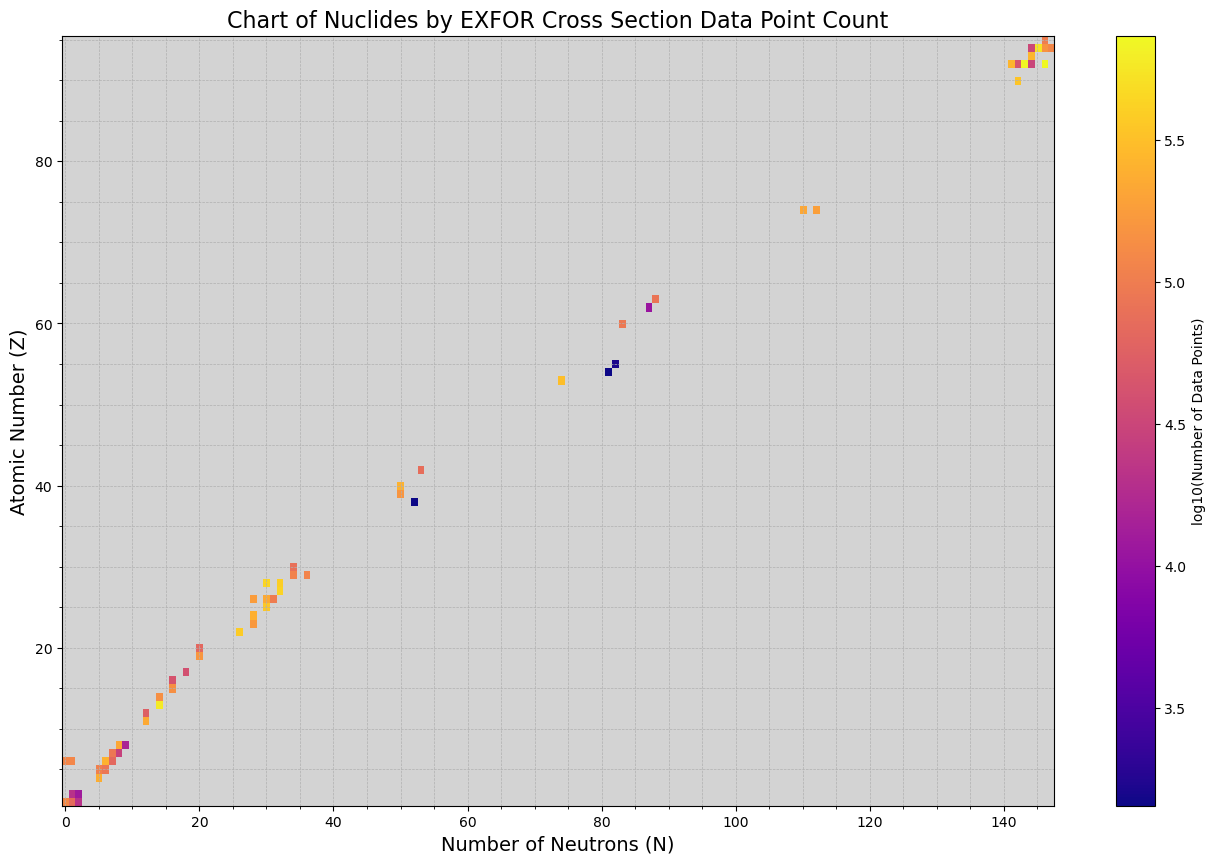

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- Plotting the Results ---

# This script assumes the 'numpy_results' array from the previous cell exists.

if 'numpy_results' in locals() and len(numpy_results) > 0:
    print("Preparing data for plotting...")
    
    # A lookup map to get Atomic Number (Z) from the element symbol
    element_z_map = {
        'H': 1, 'HE': 2, 'LI': 6, 'BE': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'NA': 11,
        'MG': 12, 'AL': 13, 'SI': 14, 'P': 15, 'S': 16, 'CL': 17, 'K': 19, 'CA': 20,
        'TI': 22, 'V': 23, 'CR': 24, 'MN': 25, 'FE': 26, 'CO': 27, 'NI': 28, 'CU': 29,
        'ZN': 30, 'SR': 38, 'Y': 39, 'ZR': 40, 'MO': 42, 'I': 53, 'XE': 54, 'CS': 55,
        'ND': 60, 'SM': 62, 'EU': 63, 'W': 74, 'TH': 90, 'U': 92, 'NP': 93, 'PU': 94,
        'AM': 95
    }

    protons = []
    neutrons = []
    counts = []

    for row in numpy_results:
        try:
            parts = row['isotope'].split('-')
            symbol = parts[0].upper()
            A = int(parts[1])
            Z = element_z_map[symbol]
            N = A - Z
            
            protons.append(Z)
            neutrons.append(N)
            counts.append(row['count'])
        except (ValueError, IndexError, KeyError):
            continue

    # --- Create the 2D Grid for the Heatmap ---
    
    # 1. Determine the boundaries of our chart
    n_min, n_max = min(neutrons), max(neutrons)
    z_min, z_max = min(protons), max(protons)
    
    # 2. Create an empty grid filled with 'NaN' (Not a Number) for missing data
    grid_rows = z_max - z_min + 1
    grid_cols = n_max - n_min + 1
    heatmap_data = np.full((grid_rows, grid_cols), np.nan)
    
    # 3. Fill the grid with the log of the data points we have
    for Z, N, count in zip(protons, neutrons, counts):
        # Calculate the array index for each isotope
        row_idx = Z - z_min
        col_idx = N - n_min
        heatmap_data[row_idx, col_idx] = np.log10(count)

    print("Generating plot...")
    
    # --- Plotting the Grid ---
    
    plt.figure(figsize=(16, 10))
    
    # Use a colormap and set the color for 'NaN' values to light grey
    cmap = plt.get_cmap('plasma')
    cmap.set_bad(color='lightgray')

    # Use imshow to plot the 2D grid
    im = plt.imshow(
        heatmap_data, 
        cmap=cmap, 
        origin='lower',
        extent=[n_min - 0.5, n_max + 0.5, z_min - 0.5, z_max + 0.5],
        aspect='auto'
    )
    
    plt.xlabel('Number of Neutrons (N)', fontsize=14)
    plt.ylabel('Atomic Number (Z)', fontsize=14)
    plt.title('Chart of Nuclides by EXFOR Cross Section Data Point Count', fontsize=16)
    
    cbar = plt.colorbar(im, label='log10(Number of Data Points)')
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    
    plt.savefig('nuclide_heatmap.png', dpi=300, bbox_inches='tight')
    
    print("\nPlot has been generated and saved as 'nuclide_heatmap.png'")

else:
    print("The 'numpy_results' array was not found or is empty. Please run the analysis cell first.")

using this website for isotopes. https://periodictable.com/Properties/A/KnownIsotopes.an.html

In [6]:
import re
import csv

# The complete text block you provided
isotope_text_block = """
Hydrogen1H, 2H, 3H, 4H, 5H, 6H, 7HHelium2He, 3He, 4He, 5He, 6He, 7He, 8He, 9He, 10HeLithium3Li, 4Li, 5Li, 6Li, 7Li, 8Li, 9Li, 10Li, 11Li, 12LiBeryllium5Be, 6Be, 7Be, 8Be, 9Be, 10Be, 11Be, 12Be, 13Be, 14Be, 15Be, 16BeBoron6B, 7B, 8B, 9B, 10B, 11B, 12B, 13B, 14B, 15B, 16B, 17B, 18B, 19BCarbon8C, 9C, 10C, 11C, 12C, 13C, 14C, 15C, 16C, 17C, 18C, 19C, 20C, 21C, 22CNitrogen10N, 11N, 12N, 13N, 14N, 15N, 16N, 17N, 18N, 19N, 20N, 21N, 22N, 23N, 24N, 25NOxygen12O, 13O, 14O, 15O, 16O, 17O, 18O, 19O, 20O, 21O, 22O, 23O, 24O, 25O, 26O, 27O, 28OFluorine14F, 15F, 16F, 17F, 18F, 19F, 20F, 21F, 22F, 23F, 24F, 25F, 26F, 27F, 28F, 29F, 30F, 31FNeon16Ne, 17Ne, 18Ne, 19Ne, 20Ne, 21Ne, 22Ne, 23Ne, 24Ne, 25Ne, 26Ne, 27Ne, 28Ne, 29Ne, 30Ne, 31Ne, 32Ne, 33Ne, 34NeSodium18Na, 19Na, 20Na, 21Na, 22Na, 23Na, 24Na, 25Na, 26Na, 27Na, 28Na, 29Na, 30Na, 31Na, 32Na, 33Na, 34Na, 35Na, 36Na, 37NaMagnesium19Mg, 20Mg, 21Mg, 22Mg, 23Mg, 24Mg, 25Mg, 26Mg, 27Mg, 28Mg, 29Mg, 30Mg, 31Mg, 32Mg, 33Mg, 34Mg, 35Mg, 36Mg, 37Mg, 38Mg, 39Mg, 40MgAluminum21Al, 22Al, 23Al, 24Al, 25Al, 26Al, 27Al, 28Al, 29Al, 30Al, 31Al, 32Al, 33Al, 34Al, 35Al, 36Al, 37Al, 38Al, 39Al, 40Al, 41Al, 42AlSilicon22Si, 23Si, 24Si, 25Si, 26Si, 27Si, 28Si, 29Si, 30Si, 31Si, 32Si, 33Si, 34Si, 35Si, 36Si, 37Si, 38Si, 39Si, 40Si, 41Si, 42Si, 43Si, 44SiPhosphorus24P, 25P, 26P, 27P, 28P, 29P, 30P, 31P, 32P, 33P, 34P, 35P, 36P, 37P, 38P, 39P, 40P, 41P, 42P, 43P, 44P, 45P, 46PSulfur26S, 27S, 28S, 29S, 30S, 31S, 32S, 33S, 34S, 35S, 36S, 37S, 38S, 39S, 40S, 41S, 42S, 43S, 44S, 45S, 46S, 47S, 48S, 49SChlorine28Cl, 29Cl, 30Cl, 31Cl, 32Cl, 33Cl, 34Cl, 35Cl, 36Cl, 37Cl, 38Cl, 39Cl, 40Cl, 41Cl, 42Cl, 43Cl, 44Cl, 45Cl, 46Cl, 47Cl, 48Cl, 49Cl, 50Cl, 51ClArgon30Ar, 31Ar, 32Ar, 33Ar, 34Ar, 35Ar, 36Ar, 37Ar, 38Ar, 39Ar, 40Ar, 41Ar, 42Ar, 43Ar, 44Ar, 45Ar, 46Ar, 47Ar, 48Ar, 49Ar, 50Ar, 51Ar, 52Ar, 53ArPotassium32K, 33K, 34K, 35K, 36K, 37K, 38K, 39K, 40K, 41K, 42K, 43K, 44K, 45K, 46K, 47K, 48K, 49K, 50K, 51K, 52K, 53K, 54K, 55KCalcium34Ca, 35Ca, 36Ca, 37Ca, 38Ca, 39Ca, 40Ca, 41Ca, 42Ca, 43Ca, 44Ca, 45Ca, 46Ca, 47Ca, 48Ca, 49Ca, 50Ca, 51Ca, 52Ca, 53Ca, 54Ca, 55Ca, 56Ca, 57CaScandium36Sc, 37Sc, 38Sc, 39Sc, 40Sc, 41Sc, 42Sc, 43Sc, 44Sc, 45Sc, 46Sc, 47Sc, 48Sc, 49Sc, 50Sc, 51Sc, 52Sc, 53Sc, 54Sc, 55Sc, 56Sc, 57Sc, 58Sc, 59Sc, 60ScTitanium38Ti, 39Ti, 40Ti, 41Ti, 42Ti, 43Ti, 44Ti, 45Ti, 46Ti, 47Ti, 48Ti, 49Ti, 50Ti, 51Ti, 52Ti, 53Ti, 54Ti, 55Ti, 56Ti, 57Ti, 58Ti, 59Ti, 60Ti, 61Ti, 62Ti, 63TiVanadium40V, 41V, 42V, 43V, 44V, 45V, 46V, 47V, 48V, 49V, 50V, 51V, 52V, 53V, 54V, 55V, 56V, 57V, 58V, 59V, 60V, 61V, 62V, 63V, 64V, 65VChromium42Cr, 43Cr, 44Cr, 45Cr, 46Cr, 47Cr, 48Cr, 49Cr, 50Cr, 51Cr, 52Cr, 53Cr, 54Cr, 55Cr, 56Cr, 57Cr, 58Cr, 59Cr, 60Cr, 61Cr, 62Cr, 63Cr, 64Cr, 65Cr, 66Cr, 67CrManganese44Mn, 45Mn, 46Mn, 47Mn, 48Mn, 49Mn, 50Mn, 51Mn, 52Mn, 53Mn, 54Mn, 55Mn, 56Mn, 57Mn, 58Mn, 59Mn, 60Mn, 61Mn, 62Mn, 63Mn, 64Mn, 65Mn, 66Mn, 67Mn, 68Mn, 69MnIron45Fe, 46Fe, 47Fe, 48Fe, 49Fe, 50Fe, 51Fe, 52Fe, 53Fe, 54Fe, 55Fe, 56Fe, 57Fe, 58Fe, 59Fe, 60Fe, 61Fe, 62Fe, 63Fe, 64Fe, 65Fe, 66Fe, 67Fe, 68Fe, 69Fe, 70Fe, 71Fe, 72FeCobalt47Co, 48Co, 49Co, 50Co, 51Co, 52Co, 53Co, 54Co, 55Co, 56Co, 57Co, 58Co, 59Co, 60Co, 61Co, 62Co, 63Co, 64Co, 65Co, 66Co, 67Co, 68Co, 69Co, 70Co, 71Co, 72Co, 73Co, 74Co, 75CoNickel48Ni, 49Ni, 50Ni, 51Ni, 52Ni, 53Ni, 54Ni, 55Ni, 56Ni, 57Ni, 58Ni, 59Ni, 60Ni, 61Ni, 62Ni, 63Ni, 64Ni, 65Ni, 66Ni, 67Ni, 68Ni, 69Ni, 70Ni, 71Ni, 72Ni, 73Ni, 74Ni, 75Ni, 76Ni, 77Ni, 78NiCopper52Cu, 53Cu, 54Cu, 55Cu, 56Cu, 57Cu, 58Cu, 59Cu, 60Cu, 61Cu, 62Cu, 63Cu, 64Cu, 65Cu, 66Cu, 67Cu, 68Cu, 69Cu, 70Cu, 71Cu, 72Cu, 73Cu, 74Cu, 75Cu, 76Cu, 77Cu, 78Cu, 79Cu, 80CuZinc54Zn, 55Zn, 56Zn, 57Zn, 58Zn, 59Zn, 60Zn, 61Zn, 62Zn, 63Zn, 64Zn, 65Zn, 66Zn, 67Zn, 68Zn, 69Zn, 70Zn, 71Zn, 72Zn, 73Zn, 74Zn, 75Zn, 76Zn, 77Zn, 78Zn, 79Zn, 80Zn, 81Zn, 82Zn, 83ZnGallium56Ga, 57Ga, 58Ga, 59Ga, 60Ga, 61Ga, 62Ga, 63Ga, 64Ga, 65Ga, 66Ga, 67Ga, 68Ga, 69Ga, 70Ga, 71Ga, 72Ga, 73Ga, 74Ga, 75Ga, 76Ga, 77Ga, 78Ga, 79Ga, 80Ga, 81Ga, 82Ga, 83Ga, 84Ga, 85Ga, 86GaGermanium58Ge, 59Ge, 60Ge, 61Ge, 62Ge, 63Ge, 64Ge, 65Ge, 66Ge, 67Ge, 68Ge, 69Ge, 70Ge, 71Ge, 72Ge, 73Ge, 74Ge, 75Ge, 76Ge, 77Ge, 78Ge, 79Ge, 80Ge, 81Ge, 82Ge, 83Ge, 84Ge, 85Ge, 86Ge, 87Ge, 88Ge, 89GeArsenic60As, 61As, 62As, 63As, 64As, 65As, 66As, 67As, 68As, 69As, 70As, 71As, 72As, 73As, 74As, 75As, 76As, 77As, 78As, 79As, 80As, 81As, 82As, 83As, 84As, 85As, 86As, 87As, 88As, 89As, 90As, 91As, 92AsSelenium65Se, 66Se, 67Se, 68Se, 69Se, 70Se, 71Se, 72Se, 73Se, 74Se, 75Se, 76Se, 77Se, 78Se, 79Se, 80Se, 81Se, 82Se, 83Se, 84Se, 85Se, 86Se, 87Se, 88Se, 89Se, 90Se, 91Se, 92Se, 93Se, 94SeBromine67Br, 68Br, 69Br, 70Br, 71Br, 72Br, 73Br, 74Br, 75Br, 76Br, 77Br, 78Br, 79Br, 80Br, 81Br, 82Br, 83Br, 84Br, 85Br, 86Br, 87Br, 88Br, 89Br, 90Br, 91Br, 92Br, 93Br, 94Br, 95Br, 96Br, 97BrKrypton69Kr, 70Kr, 71Kr, 72Kr, 73Kr, 74Kr, 75Kr, 76Kr, 77Kr, 78Kr, 79Kr, 80Kr, 81Kr, 82Kr, 83Kr, 84Kr, 85Kr, 86Kr, 87Kr, 88Kr, 89Kr, 90Kr, 91Kr, 92Kr, 93Kr, 94Kr, 95Kr, 96Kr, 97Kr, 98Kr, 99Kr, 100KrRubidium71Rb, 72Rb, 73Rb, 74Rb, 75Rb, 76Rb, 77Rb, 78Rb, 79Rb, 80Rb, 81Rb, 82Rb, 83Rb, 84Rb, 85Rb, 86Rb, 87Rb, 88Rb, 89Rb, 90Rb, 91Rb, 92Rb, 93Rb, 94Rb, 95Rb, 96Rb, 97Rb, 98Rb, 99Rb, 100Rb, 101Rb, 102RbStrontium73Sr, 74Sr, 75Sr, 76Sr, 77Sr, 78Sr, 79Sr, 80Sr, 81Sr, 82Sr, 83Sr, 84Sr, 85Sr, 86Sr, 87Sr, 88Sr, 89Sr, 90Sr, 91Sr, 92Sr, 93Sr, 94Sr, 95Sr, 96Sr, 97Sr, 98Sr, 99Sr, 100Sr, 101Sr, 102Sr, 103Sr, 104Sr, 105SrYttrium76Y, 77Y, 78Y, 79Y, 80Y, 81Y, 82Y, 83Y, 84Y, 85Y, 86Y, 87Y, 88Y, 89Y, 90Y, 91Y, 92Y, 93Y, 94Y, 95Y, 96Y, 97Y, 98Y, 99Y, 100Y, 101Y, 102Y, 103Y, 104Y, 105Y, 106Y, 107Y, 108YZirconium78Zr, 79Zr, 80Zr, 81Zr, 82Zr, 83Zr, 84Zr, 85Zr, 86Zr, 87Zr, 88Zr, 89Zr, 90Zr, 91Zr, 92Zr, 93Zr, 94Zr, 95Zr, 96Zr, 97Zr, 98Zr, 99Zr, 100Zr, 101Zr, 102Zr, 103Zr, 104Zr, 105Zr, 106Zr, 107Zr, 108Zr, 109Zr, 110ZrNiobium81Nb, 82Nb, 83Nb, 84Nb, 85Nb, 86Nb, 87Nb, 88Nb, 89Nb, 90Nb, 91Nb, 92Nb, 93Nb, 94Nb, 95Nb, 96Nb, 97Nb, 98Nb, 99Nb, 100Nb, 101Nb, 102Nb, 103Nb, 104Nb, 105Nb, 106Nb, 107Nb, 108Nb, 109Nb, 110Nb, 111Nb, 112Nb, 113NbMolybdenum83Mo, 84Mo, 85Mo, 86Mo, 87Mo, 88Mo, 89Mo, 90Mo, 91Mo, 92Mo, 93Mo, 94Mo, 95Mo, 96Mo, 97Mo, 98Mo, 99Mo, 100Mo, 101Mo, 102Mo, 103Mo, 104Mo, 105Mo, 106Mo, 107Mo, 108Mo, 109Mo, 110Mo, 111Mo, 112Mo, 113Mo, 114Mo, 115MoTechnetium85Tc, 86Tc, 87Tc, 88Tc, 89Tc, 90Tc, 91Tc, 92Tc, 93Tc, 94Tc, 95Tc, 96Tc, 97Tc, 98Tc, 99Tc, 100Tc, 101Tc, 102Tc, 103Tc, 104Tc, 105Tc, 106Tc, 107Tc, 108Tc, 109Tc, 110Tc, 111Tc, 112Tc, 113Tc, 114Tc, 115Tc, 116Tc, 117Tc, 118TcRuthenium87Ru, 88Ru, 89Ru, 90Ru, 91Ru, 92Ru, 93Ru, 94Ru, 95Ru, 96Ru, 97Ru, 98Ru, 99Ru, 100Ru, 101Ru, 102Ru, 103Ru, 104Ru, 105Ru, 106Ru, 107Ru, 108Ru, 109Ru, 110Ru, 111Ru, 112Ru, 113Ru, 114Ru, 115Ru, 116Ru, 117Ru, 118Ru, 119Ru, 120RuRhodium89Rh, 90Rh, 91Rh, 92Rh, 93Rh, 94Rh, 95Rh, 96Rh, 97Rh, 98Rh, 99Rh, 100Rh, 101Rh, 102Rh, 103Rh, 104Rh, 105Rh, 106Rh, 107Rh, 108Rh, 109Rh, 110Rh, 111Rh, 112Rh, 113Rh, 114Rh, 115Rh, 116Rh, 117Rh, 118Rh, 119Rh, 120Rh, 121Rh, 122RhPalladium91Pd, 92Pd, 93Pd, 94Pd, 95Pd, 96Pd, 97Pd, 98Pd, 99Pd, 100Pd, 101Pd, 102Pd, 103Pd, 104Pd, 105Pd, 106Pd, 107Pd, 108Pd, 109Pd, 110Pd, 111Pd, 112Pd, 113Pd, 114Pd, 115Pd, 116Pd, 117Pd, 118Pd, 119Pd, 120Pd, 121Pd, 122Pd, 123Pd, 124PdSilver93Ag, 94Ag, 95Ag, 96Ag, 97Ag, 98Ag, 99Ag, 100Ag, 101Ag, 102Ag, 103Ag, 104Ag, 105Ag, 106Ag, 107Ag, 108Ag, 109Ag, 110Ag, 111Ag, 112Ag, 113Ag, 114Ag, 115Ag, 116Ag, 117Ag, 118Ag, 119Ag, 120Ag, 121Ag, 122Ag, 123Ag, 124Ag, 125Ag, 126Ag, 127Ag, 128Ag, 129Ag, 130AgCadmium95Cd, 96Cd, 97Cd, 98Cd, 99Cd, 100Cd, 101Cd, 102Cd, 103Cd, 104Cd, 105Cd, 106Cd, 107Cd, 108Cd, 109Cd, 110Cd, 111Cd, 112Cd, 113Cd, 114Cd, 115Cd, 116Cd, 117Cd, 118Cd, 119Cd, 120Cd, 121Cd, 122Cd, 123Cd, 124Cd, 125Cd, 126Cd, 127Cd, 128Cd, 129Cd, 130Cd, 131Cd, 132CdIndium97In, 98In, 99In, 100In, 101In, 102In, 103In, 104In, 105In, 106In, 107In, 108In, 109In, 110In, 111In, 112In, 113In, 114In, 115In, 116In, 117In, 118In, 119In, 120In, 121In, 122In, 123In, 124In, 125In, 126In, 127In, 128In, 129In, 130In, 131In, 132In, 133In, 134In, 135InTin99Sn, 100Sn, 101Sn, 102Sn, 103Sn, 104Sn, 105Sn, 106Sn, 107Sn, 108Sn, 109Sn, 110Sn, 111Sn, 112Sn, 113Sn, 114Sn, 115Sn, 116Sn, 117Sn, 118Sn, 119Sn, 120Sn, 121Sn, 122Sn, 123Sn, 124Sn, 125Sn, 126Sn, 127Sn, 128Sn, 129Sn, 130Sn, 131Sn, 132Sn, 133Sn, 134Sn, 135Sn, 136Sn, 137SnAntimony103Sb, 104Sb, 105Sb, 106Sb, 107Sb, 108Sb, 109Sb, 110Sb, 111Sb, 112Sb, 113Sb, 114Sb, 115Sb, 116Sb, 117Sb, 118Sb, 119Sb, 120Sb, 121Sb, 122Sb, 123Sb, 124Sb, 125Sb, 126Sb, 127Sb, 128Sb, 129Sb, 130Sb, 131Sb, 132Sb, 133Sb, 134Sb, 135Sb, 136Sb, 137Sb, 138Sb, 139SbTellurium105Te, 106Te, 107Te, 108Te, 109Te, 110Te, 111Te, 112Te, 113Te, 114Te, 115Te, 116Te, 117Te, 118Te, 119Te, 120Te, 121Te, 122Te, 123Te, 124Te, 125Te, 126Te, 127Te, 128Te, 129Te, 130Te, 131Te, 132Te, 133Te, 134Te, 135Te, 136Te, 137Te, 138Te, 139Te, 140Te, 141Te, 142TeIodine108I, 109I, 110I, 111I, 112I, 113I, 114I, 115I, 116I, 117I, 118I, 119I, 120I, 121I, 122I, 123I, 124I, 125I, 126I, 127I, 128I, 129I, 130I, 131I, 132I, 133I, 134I, 135I, 136I, 137I, 138I, 139I, 140I, 141I, 142I, 143I, 144IXenon110Xe, 111Xe, 112Xe, 113Xe, 114Xe, 115Xe, 116Xe, 117Xe, 118Xe, 119Xe, 120Xe, 121Xe, 122Xe, 123Xe, 124Xe, 125Xe, 126Xe, 127Xe, 128Xe, 129Xe, 130Xe, 131Xe, 132Xe, 133Xe, 134Xe, 135Xe, 136Xe, 137Xe, 138Xe, 139Xe, 140Xe, 141Xe, 142Xe, 143Xe, 144Xe, 145Xe, 146Xe, 147XeCesium112Cs, 113Cs, 114Cs, 115Cs, 116Cs, 117Cs, 118Cs, 119Cs, 120Cs, 121Cs, 122Cs, 123Cs, 124Cs, 125Cs, 126Cs, 127Cs, 128Cs, 129Cs, 130Cs, 131Cs, 132Cs, 133Cs, 134Cs, 135Cs, 136Cs, 137Cs, 138Cs, 139Cs, 140Cs, 141Cs, 142Cs, 143Cs, 144Cs, 145Cs, 146Cs, 147Cs, 148Cs, 149Cs, 150Cs, 151CsBarium114Ba, 115Ba, 116Ba, 117Ba, 118Ba, 119Ba, 120Ba, 121Ba, 122Ba, 123Ba, 124Ba, 125Ba, 126Ba, 127Ba, 128Ba, 129Ba, 130Ba, 131Ba, 132Ba, 133Ba, 134Ba, 135Ba, 136Ba, 137Ba, 138Ba, 139Ba, 140Ba, 141Ba, 142Ba, 143Ba, 144Ba, 145Ba, 146Ba, 147Ba, 148Ba, 149Ba, 150Ba, 151Ba, 152Ba, 153BaLanthanum117La, 118La, 119La, 120La, 121La, 122La, 123La, 124La, 125La, 126La, 127La, 128La, 129La, 130La, 131La, 132La, 133La, 134La, 135La, 136La, 137La, 138La, 139La, 140La, 141La, 142La, 143La, 144La, 145La, 146La, 147La, 148La, 149La, 150La, 151La, 152La, 153La, 154La, 155LaCerium119Ce, 120Ce, 121Ce, 122Ce, 123Ce, 124Ce, 125Ce, 126Ce, 127Ce, 128Ce, 129Ce, 130Ce, 131Ce, 132Ce, 133Ce, 134Ce, 135Ce, 136Ce, 137Ce, 138Ce, 139Ce, 140Ce, 141Ce, 142Ce, 143Ce, 144Ce, 145Ce, 146Ce, 147Ce, 148Ce, 149Ce, 150Ce, 151Ce, 152Ce, 153Ce, 154Ce, 155Ce, 156Ce, 157CePraseodymium121Pr, 122Pr, 123Pr, 124Pr, 125Pr, 126Pr, 127Pr, 128Pr, 129Pr, 130Pr, 131Pr, 132Pr, 133Pr, 134Pr, 135Pr, 136Pr, 137Pr, 138Pr, 139Pr, 140Pr, 141Pr, 142Pr, 143Pr, 144Pr, 145Pr, 146Pr, 147Pr, 148Pr, 149Pr, 150Pr, 151Pr, 152Pr, 153Pr, 154Pr, 155Pr, 156Pr, 157Pr, 158Pr, 159PrNeodymium124Nd, 125Nd, 126Nd, 127Nd, 128Nd, 129Nd, 130Nd, 131Nd, 132Nd, 133Nd, 134Nd, 135Nd, 136Nd, 137Nd, 138Nd, 139Nd, 140Nd, 141Nd, 142Nd, 143Nd, 144Nd, 145Nd, 146Nd, 147Nd, 148Nd, 149Nd, 150Nd, 151Nd, 152Nd, 153Nd, 154Nd, 155Nd, 156Nd, 157Nd, 158Nd, 159Nd, 160Nd, 161NdPromethium126Pm, 127Pm, 128Pm, 129Pm, 130Pm, 131Pm, 132Pm, 133Pm, 134Pm, 135Pm, 136Pm, 137Pm, 138Pm, 139Pm, 140Pm, 141Pm, 142Pm, 143Pm, 144Pm, 145Pm, 146Pm, 147Pm, 148Pm, 149Pm, 150Pm, 151Pm, 152Pm, 153Pm, 154Pm, 155Pm, 156Pm, 157Pm, 158Pm, 159Pm, 160Pm, 161Pm, 162Pm, 163PmSamarium128Sm, 129Sm, 130Sm, 131Sm, 132Sm, 133Sm, 134Sm, 135Sm, 136Sm, 137Sm, 138Sm, 139Sm, 140Sm, 141Sm, 142Sm, 143Sm, 144Sm, 145Sm, 146Sm, 147Sm, 148Sm, 149Sm, 150Sm, 151Sm, 152Sm, 153Sm, 154Sm, 155Sm, 156Sm, 157Sm, 158Sm, 159Sm, 160Sm, 161Sm, 162Sm, 163Sm, 164Sm, 165SmEuropium130Eu, 131Eu, 132Eu, 133Eu, 134Eu, 135Eu, 136Eu, 137Eu, 138Eu, 139Eu, 140Eu, 141Eu, 142Eu, 143Eu, 144Eu, 145Eu, 146Eu, 147Eu, 148Eu, 149Eu, 150Eu, 151Eu, 152Eu, 153Eu, 154Eu, 155Eu, 156Eu, 157Eu, 158Eu, 159Eu, 160Eu, 161Eu, 162Eu, 163Eu, 164Eu, 165Eu, 166Eu, 167EuGadolinium134Gd, 135Gd, 136Gd, 137Gd, 138Gd, 139Gd, 140Gd, 141Gd, 142Gd, 143Gd, 144Gd, 145Gd, 146Gd, 147Gd, 148Gd, 149Gd, 150Gd, 151Gd, 152Gd, 153Gd, 154Gd, 155Gd, 156Gd, 157Gd, 158Gd, 159Gd, 160Gd, 161Gd, 162Gd, 163Gd, 164Gd, 165Gd, 166Gd, 167Gd, 168Gd, 169GdTerbium136Tb, 137Tb, 138Tb, 139Tb, 140Tb, 141Tb, 142Tb, 143Tb, 144Tb, 145Tb, 146Tb, 147Tb, 148Tb, 149Tb, 150Tb, 151Tb, 152Tb, 153Tb, 154Tb, 155Tb, 156Tb, 157Tb, 158Tb, 159Tb, 160Tb, 161Tb, 162Tb, 163Tb, 164Tb, 165Tb, 166Tb, 167Tb, 168Tb, 169Tb, 170Tb, 171TbDysprosium138Dy, 139Dy, 140Dy, 141Dy, 142Dy, 143Dy, 144Dy, 145Dy, 146Dy, 147Dy, 148Dy, 149Dy, 150Dy, 151Dy, 152Dy, 153Dy, 154Dy, 155Dy, 156Dy, 157Dy, 158Dy, 159Dy, 160Dy, 161Dy, 162Dy, 163Dy, 164Dy, 165Dy, 166Dy, 167Dy, 168Dy, 169Dy, 170Dy, 171Dy, 172Dy, 173DyHolmium140Ho, 141Ho, 142Ho, 143Ho, 144Ho, 145Ho, 146Ho, 147Ho, 148Ho, 149Ho, 150Ho, 151Ho, 152Ho, 153Ho, 154Ho, 155Ho, 156Ho, 157Ho, 158Ho, 159Ho, 160Ho, 161Ho, 162Ho, 163Ho, 164Ho, 165Ho, 166Ho, 167Ho, 168Ho, 169Ho, 170Ho, 171Ho, 172Ho, 173Ho, 174Ho, 175HoErbium143Er, 144Er, 145Er, 146Er, 147Er, 148Er, 149Er, 150Er, 151Er, 152Er, 153Er, 154Er, 155Er, 156Er, 157Er, 158Er, 159Er, 160Er, 161Er, 162Er, 163Er, 164Er, 165Er, 166Er, 167Er, 168Er, 169Er, 170Er, 171Er, 172Er, 173Er, 174Er, 175Er, 176Er, 177ErThulium145Tm, 146Tm, 147Tm, 148Tm, 149Tm, 150Tm, 151Tm, 152Tm, 153Tm, 154Tm, 155Tm, 156Tm, 157Tm, 158Tm, 159Tm, 160Tm, 161Tm, 162Tm, 163Tm, 164Tm, 165Tm, 166Tm, 167Tm, 168Tm, 169Tm, 170Tm, 171Tm, 172Tm, 173Tm, 174Tm, 175Tm, 176Tm, 177Tm, 178Tm, 179TmYtterbium148Yb, 149Yb, 150Yb, 151Yb, 152Yb, 153Yb, 154Yb, 155Yb, 156Yb, 157Yb, 158Yb, 159Yb, 160Yb, 161Yb, 162Yb, 163Yb, 164Yb, 165Yb, 166Yb, 167Yb, 168Yb, 169Yb, 170Yb, 171Yb, 172Yb, 173Yb, 174Yb, 175Yb, 176Yb, 177Yb, 178Yb, 179Yb, 180Yb, 181Yb, 182YbLutetium150Lu, 151Lu, 152Lu, 153Lu, 154Lu, 155Lu, 156Lu, 157Lu, 158Lu, 159Lu, 160Lu, 161Lu, 162Lu, 163Lu, 164Lu, 165Lu, 166Lu, 167Lu, 168Lu, 169Lu, 170Lu, 171Lu, 172Lu, 173Lu, 174Lu, 175Lu, 176Lu, 177Lu, 178Lu, 179Lu, 180Lu, 181Lu, 182Lu, 183Lu, 184LuHafnium153Hf, 154Hf, 155Hf, 156Hf, 157Hf, 158Hf, 159Hf, 160Hf, 161Hf, 162Hf, 163Hf, 164Hf, 165Hf, 166Hf, 167Hf, 168Hf, 169Hf, 170Hf, 171Hf, 172Hf, 173Hf, 174Hf, 175Hf, 176Hf, 177Hf, 178Hf, 179Hf, 180Hf, 181Hf, 182Hf, 183Hf, 184Hf, 185Hf, 186Hf, 187Hf, 188HfTantalum155Ta, 156Ta, 157Ta, 158Ta, 159Ta, 160Ta, 161Ta, 162Ta, 163Ta, 164Ta, 165Ta, 166Ta, 167Ta, 168Ta, 169Ta, 170Ta, 171Ta, 172Ta, 173Ta, 174Ta, 175Ta, 176Ta, 177Ta, 178Ta, 179Ta, 180Ta, 181Ta, 182Ta, 183Ta, 184Ta, 185Ta, 186Ta, 187Ta, 188Ta, 189Ta, 190TaTungsten158W, 159W, 160W, 161W, 162W, 163W, 164W, 165W, 166W, 167W, 168W, 169W, 170W, 171W, 172W, 173W, 174W, 175W, 176W, 177W, 178W, 179W, 180W, 181W, 182W, 183W, 184W, 185W, 186W, 187W, 188W, 189W, 190W, 191W, 192WRhenium160Re, 161Re, 162Re, 163Re, 164Re, 165Re, 166Re, 167Re, 168Re, 169Re, 170Re, 171Re, 172Re, 173Re, 174Re, 175Re, 176Re, 177Re, 178Re, 179Re, 180Re, 181Re, 182Re, 183Re, 184Re, 185Re, 186Re, 187Re, 188Re, 189Re, 190Re, 191Re, 192Re, 193Re, 194ReOsmium162Os, 163Os, 164Os, 165Os, 166Os, 167Os, 168Os, 169Os, 170Os, 171Os, 172Os, 173Os, 174Os, 175Os, 176Os, 177Os, 178Os, 179Os, 180Os, 181Os, 182Os, 183Os, 184Os, 185Os, 186Os, 187Os, 188Os, 189Os, 190Os, 191Os, 192Os, 193Os, 194Os, 195Os, 196OsIridium164Ir, 165Ir, 166Ir, 167Ir, 168Ir, 169Ir, 170Ir, 171Ir, 172Ir, 173Ir, 174Ir, 175Ir, 176Ir, 177Ir, 178Ir, 179Ir, 180Ir, 181Ir, 182Ir, 183Ir, 184Ir, 185Ir, 186Ir, 187Ir, 188Ir, 189Ir, 190Ir, 191Ir, 192Ir, 193Ir, 194Ir, 195Ir, 196Ir, 197Ir, 198Ir, 199IrPlatinum166Pt, 167Pt, 168Pt, 169Pt, 170Pt, 171Pt, 172Pt, 173Pt, 174Pt, 175Pt, 176Pt, 177Pt, 178Pt, 179Pt, 180Pt, 181Pt, 182Pt, 183Pt, 184Pt, 185Pt, 186Pt, 187Pt, 188Pt, 189Pt, 190Pt, 191Pt, 192Pt, 193Pt, 194Pt, 195Pt, 196Pt, 197Pt, 198Pt, 199Pt, 200Pt, 201Pt, 202PtGold169Au, 170Au, 171Au, 172Au, 173Au, 174Au, 175Au, 176Au, 177Au, 178Au, 179Au, 180Au, 181Au, 182Au, 183Au, 184Au, 185Au, 186Au, 187Au, 188Au, 189Au, 190Au, 191Au, 192Au, 193Au, 194Au, 195Au, 196Au, 197Au, 198Au, 199Au, 200Au, 201Au, 202Au, 203Au, 204Au, 205AuMercury171Hg, 172Hg, 173Hg, 174Hg, 175Hg, 176Hg, 177Hg, 178Hg, 179Hg, 180Hg, 181Hg, 182Hg, 183Hg, 184Hg, 185Hg, 186Hg, 187Hg, 188Hg, 189Hg, 190Hg, 191Hg, 192Hg, 193Hg, 194Hg, 195Hg, 196Hg, 197Hg, 198Hg, 199Hg, 200Hg, 201Hg, 202Hg, 203Hg, 204Hg, 205Hg, 206Hg, 207Hg, 208Hg, 209Hg, 210HgThallium176Tl, 177Tl, 178Tl, 179Tl, 180Tl, 181Tl, 182Tl, 183Tl, 184Tl, 185Tl, 186Tl, 187Tl, 188Tl, 189Tl, 190Tl, 191Tl, 192Tl, 193Tl, 194Tl, 195Tl, 196Tl, 197Tl, 198Tl, 199Tl, 200Tl, 201Tl, 202Tl, 203Tl, 204Tl, 205Tl, 206Tl, 207Tl, 208Tl, 209Tl, 210Tl, 211Tl, 212TlLead178Pb, 179Pb, 180Pb, 181Pb, 182Pb, 183Pb, 184Pb, 185Pb, 186Pb, 187Pb, 188Pb, 189Pb, 190Pb, 191Pb, 192Pb, 193Pb, 194Pb, 195Pb, 196Pb, 197Pb, 198Pb, 199Pb, 200Pb, 201Pb, 202Pb, 203Pb, 204Pb, 205Pb, 206Pb, 207Pb, 208Pb, 209Pb, 210Pb, 211Pb, 212Pb, 213Pb, 214Pb, 215PbBismuth184Bi, 185Bi, 186Bi, 187Bi, 188Bi, 189Bi, 190Bi, 191Bi, 192Bi, 193Bi, 194Bi, 195Bi, 196Bi, 197Bi, 198Bi, 199Bi, 200Bi, 201Bi, 202Bi, 203Bi, 204Bi, 205Bi, 206Bi, 207Bi, 208Bi, 209Bi, 210Bi, 211Bi, 212Bi, 213Bi, 214Bi, 215Bi, 216Bi, 217Bi, 218Bi, 219BiPolonium188Po, 189Po, 190Po, 191Po, 192Po, 193Po, 194Po, 195Po, 196Po, 197Po, 198Po, 199Po, 200Po, 201Po, 202Po, 203Po, 204Po, 205Po, 206Po, 207Po, 208Po, 209Po, 210Po, 211Po, 212Po, 213Po, 214Po, 215Po, 216Po, 217Po, 218Po, 219Po, 220PoAstatine193At, 194At, 195At, 196At, 197At, 198At, 199At, 200At, 201At, 202At, 203At, 204At, 205At, 206At, 207At, 208At, 209At, 210At, 211At, 212At, 213At, 214At, 215At, 216At, 217At, 218At, 219At, 220At, 221At, 222At, 223AtRadon195Rn, 196Rn, 197Rn, 198Rn, 199Rn, 200Rn, 201Rn, 202Rn, 203Rn, 204Rn, 205Rn, 206Rn, 207Rn, 208Rn, 209Rn, 210Rn, 211Rn, 212Rn, 213Rn, 214Rn, 215Rn, 216Rn, 217Rn, 218Rn, 219Rn, 220Rn, 221Rn, 222Rn, 223Rn, 224Rn, 225Rn, 226Rn, 227Rn, 228RnFrancium199Fr, 200Fr, 201Fr, 202Fr, 203Fr, 204Fr, 205Fr, 206Fr, 207Fr, 208Fr, 209Fr, 210Fr, 211Fr, 212Fr, 213Fr, 214Fr, 215Fr, 216Fr, 217Fr, 218Fr, 219Fr, 220Fr, 221Fr, 222Fr, 223Fr, 224Fr, 225Fr, 226Fr, 227Fr, 228Fr, 229Fr, 230Fr, 231Fr, 232FrRadium202Ra, 203Ra, 204Ra, 205Ra, 206Ra, 207Ra, 208Ra, 209Ra, 210Ra, 211Ra, 212Ra, 213Ra, 214Ra, 215Ra, 216Ra, 217Ra, 218Ra, 219Ra, 220Ra, 221Ra, 222Ra, 223Ra, 224Ra, 225Ra, 226Ra, 227Ra, 228Ra, 229Ra, 230Ra, 231Ra, 232Ra, 233Ra, 234RaActinium206Ac, 207Ac, 208Ac, 209Ac, 210Ac, 211Ac, 212Ac, 213Ac, 214Ac, 215Ac, 216Ac, 217Ac, 218Ac, 219Ac, 220Ac, 221Ac, 222Ac, 223Ac, 224Ac, 225Ac, 226Ac, 227Ac, 228Ac, 229Ac, 230Ac, 231Ac, 232Ac, 233Ac, 234Ac, 235Ac, 236AcThorium209Th, 210Th, 211Th, 212Th, 213Th, 214Th, 215Th, 216Th, 217Th, 218Th, 219Th, 220Th, 221Th, 222Th, 223Th, 224Th, 225Th, 226Th, 227Th, 228Th, 229Th, 230Th, 231Th, 232Th, 233Th, 234Th, 235Th, 236Th, 237Th, 238ThProtactinium212Pa, 213Pa, 214Pa, 215Pa, 216Pa, 217Pa, 218Pa, 219Pa, 220Pa, 221Pa, 222Pa, 223Pa, 224Pa, 225Pa, 226Pa, 227Pa, 228Pa, 229Pa, 230Pa, 231Pa, 232Pa, 233Pa, 234Pa, 235Pa, 236Pa, 237Pa, 238Pa, 239Pa, 240PaUranium217U, 218U, 219U, 220U, 221U, 222U, 223U, 224U, 225U, 226U, 227U, 228U, 229U, 230U, 231U, 232U, 233U, 234U, 235U, 236U, 237U, 238U, 239U, 240U, 241U, 242UNeptunium225Np, 226Np, 227Np, 228Np, 229Np, 230Np, 231Np, 232Np, 233Np, 234Np, 235Np, 236Np, 237Np, 238Np, 239Np, 240Np, 241Np, 242Np, 243Np, 244NpPlutonium228Pu, 229Pu, 230Pu, 231Pu, 232Pu, 233Pu, 234Pu, 235Pu, 236Pu, 237Pu, 238Pu, 239Pu, 240Pu, 241Pu, 242Pu, 243Pu, 244Pu, 245Pu, 246Pu, 247PuAmericium231Am, 232Am, 233Am, 234Am, 235Am, 236Am, 237Am, 238Am, 239Am, 240Am, 241Am, 242Am, 243Am, 244Am, 245Am, 246Am, 247Am, 248Am, 249AmCurium233Cm, 234Cm, 235Cm, 236Cm, 237Cm, 238Cm, 239Cm, 240Cm, 241Cm, 242Cm, 243Cm, 244Cm, 245Cm, 246Cm, 247Cm, 248Cm, 249Cm, 250Cm, 251Cm, 252CmBerkelium235Bk, 236Bk, 237Bk, 238Bk, 239Bk, 240Bk, 241Bk, 242Bk, 243Bk, 244Bk, 245Bk, 246Bk, 247Bk, 248Bk, 249Bk, 250Bk, 251Bk, 252Bk, 253Bk, 254BkCalifornium237Cf, 238Cf, 239Cf, 240Cf, 241Cf, 242Cf, 243Cf, 244Cf, 245Cf, 246Cf, 247Cf, 248Cf, 249Cf, 250Cf, 251Cf, 252Cf, 253Cf, 254Cf, 255Cf, 256CfEinsteinium240Es, 241Es, 242Es, 243Es, 244Es, 245Es, 246Es, 247Es, 248Es, 249Es, 250Es, 251Es, 252Es, 253Es, 254Es, 255Es, 256Es, 257Es, 258EsFermium242Fm, 243Fm, 244Fm, 245Fm, 246Fm, 247Fm, 248Fm, 249Fm, 250Fm, 251Fm, 252Fm, 253Fm, 254Fm, 255Fm, 256Fm, 257Fm, 258Fm, 259Fm, 260FmMendelevium245Md, 246Md, 247Md, 248Md, 249Md, 250Md, 251Md, 252Md, 253Md, 254Md, 255Md, 256Md, 257Md, 258Md, 259Md, 260Md, 261Md, 262MdNobelium248No, 249No, 250No, 251No, 252No, 253No, 254No, 255No, 256No, 257No, 258No, 259No, 260No, 261No, 262No, 263No, 264NoLawrencium251Lr, 252Lr, 253Lr, 254Lr, 255Lr, 256Lr, 257Lr, 258Lr, 259Lr, 260Lr, 261Lr, 262Lr, 263Lr, 264Lr, 265Lr, 266LrRutherfordium253Rf, 254Rf, 255Rf, 256Rf, 257Rf, 258Rf, 259Rf, 260Rf, 261Rf, 262Rf, 263Rf, 264Rf, 265Rf, 266Rf, 267Rf, 268RfDubnium255Db, 256Db, 257Db, 258Db, 259Db, 260Db, 261Db, 262Db, 263Db, 264Db, 265Db, 266Db, 267Db, 268Db, 269Db, 270DbSeaborgium258Sg, 259Sg, 260Sg, 261Sg, 262Sg, 263Sg, 264Sg, 265Sg, 266Sg, 267Sg, 268Sg, 269Sg, 270Sg, 271Sg, 272Sg, 273SgBohrium260Bh, 261Bh, 262Bh, 263Bh, 264Bh, 265Bh, 266Bh, 267Bh, 268Bh, 269Bh, 270Bh, 271Bh, 272Bh, 273Bh, 274Bh, 275BhHassium263Hs, 264Hs, 265Hs, 266Hs, 267Hs, 268Hs, 269Hs, 270Hs, 271Hs, 272Hs, 273Hs, 274Hs, 275Hs, 276Hs, 277HsMeitnerium265Mt, 266Mt, 267Mt, 268Mt, 269Mt, 270Mt, 271Mt, 272Mt, 273Mt, 274Mt, 275Mt, 276Mt, 277Mt, 278Mt, 279MtDarmstadtium267Ds, 268Ds, 269Ds, 270Ds, 271Ds, 272Ds, 273Ds, 274Ds, 275Ds, 276Ds, 277Ds, 278Ds, 279Ds, 280Ds, 281DsRoentgenium272Rg, 273Rg, 274Rg, 275Rg, 276Rg, 277Rg, 278Rg, 279Rg, 280Rg, 281Rg, 282Rg, 283RgCopernicium277Cn, 278Cn, 279Cn, 280Cn, 281Cn, 282Cn, 283Cn, 284Cn, 285CnNihonium283Nh, 284Nh, 285Nh, 286Nh, 287NhFlerovium285Fl, 286Fl, 287Fl, 288Fl, 289FlMoscovium287Mc, 288Mc, 289Mc, 290Mc, 291McLivermorium289Lv, 290Lv, 291Lv, 292LvTennessine291Ts, 292Ts, 293Ts, 294TsOganesson293Og
"""
# This dictionary maps element names to their symbols and atomic numbers (Z)
element_data = [
    ("Hydrogen", "H", 1), ("Helium", "HE", 2), ("Lithium", "LI", 3), 
    ("Beryllium", "BE", 4), ("Boron", "B", 5), ("Carbon", "C", 6), 
    ("Nitrogen", "N", 7), ("Oxygen", "O", 8), ("Fluorine", "F", 9), 
    ("Neon", "NE", 10), ("Sodium", "NA", 11), ("Magnesium", "MG", 12), 
    ("Aluminum", "AL", 13), ("Silicon", "SI", 14), ("Phosphorus", "P", 15), 
    ("Sulfur", "S", 16), ("Chlorine", "CL", 17), ("Argon", "AR", 18), 
    ("Potassium", "K", 19), ("Calcium", "CA", 20), ("Scandium", "SC", 21), 
    ("Titanium", "TI", 22), ("Vanadium", "V", 23), ("Chromium", "CR", 24), 
    ("Manganese", "MN", 25), ("Iron", "FE", 26), ("Cobalt", "CO", 27), 
    ("Nickel", "NI", 28), ("Copper", "CU", 29), ("Zinc", "ZN", 30), 
    ("Gallium", "GA", 31), ("Germanium", "GE", 32), ("Arsenic", "AS", 33), 
    ("Selenium", "SE", 34), ("Bromine", "BR", 35), ("Krypton", "KR", 36), 
    ("Rubidium", "RB", 37), ("Strontium", "SR", 38), ("Yttrium", "Y", 39), 
    ("Zirconium", "ZR", 40), ("Niobium", "NB", 41), ("Molybdenum", "MO", 42), 
    ("Technetium", "TC", 43), ("Ruthenium", "RU", 44), ("Rhodium", "RH", 45), 
    ("Palladium", "PD", 46), ("Silver", "AG", 47), ("Cadmium", "CD", 48), 
    ("Indium", "IN", 49), ("Tin", "SN", 50), ("Antimony", "SB", 51), 
    ("Tellurium", "TE", 52), ("Iodine", "I", 53), ("Xenon", "XE", 54), 
    ("Cesium", "CS", 55), ("Barium", "BA", 56), ("Lanthanum", "LA", 57), 
    ("Cerium", "CE", 58), ("Praseodymium", "PR", 59), ("Neodymium", "ND", 60), 
    ("Promethium", "PM", 61), ("Samarium", "SM", 62), ("Europium", "EU", 63), 
    ("Gadolinium", "GD", 64), ("Terbium", "TB", 65), ("Dysprosium", "DY", 66), 
    ("Holmium", "HO", 67), ("Erbium", "ER", 68), ("Thulium", "TM", 69), 
    ("Ytterbium", "YB", 70), ("Lutetium", "LU", 71), ("Hafnium", "HF", 72), 
    ("Tantalum", "TA", 73), ("Tungsten", "W", 74), ("Rhenium", "RE", 75), 
    ("Osmium", "OS", 76), ("Iridium", "IR", 77), ("Platinum", "PT", 78), 
    ("Gold", "AU", 79), ("Mercury", "HG", 80), ("Thallium", "TL", 81), 
    ("Lead", "PB", 82), ("Bismuth", "BI", 83), ("Polonium", "PO", 84), 
    ("Astatine", "AT", 85), ("Radon", "RN", 86), ("Francium", "FR", 87), 
    ("Radium", "RA", 88), ("Actinium", "AC", 89), ("Thorium", "TH", 90), 
    ("Protactinium", "PA", 91), ("Uranium", "U", 92), ("Neptunium", "NP", 93), 
    ("Plutonium", "PU", 94), ("Americium", "AM", 95), ("Curium", "CM", 96), 
    ("Berkelium", "BK", 97), ("Californium", "CF", 98), ("Einsteinium", "ES", 99), 
    ("Fermium", "FM", 100), ("Mendelevium", "MD", 101), ("Nobelium", "NO", 102), 
    ("Lawrencium", "LR", 103), ("Rutherfordium", "RF", 104), ("Dubnium", "DB", 105), 
    ("Seaborgium", "SG", 106), ("Bohrium", "BH", 107), ("Hassium", "HS", 108), 
    ("Meitnerium", "MT", 109), ("Darmstadtium", "DS", 110), ("Roentgenium", "RG", 111), 
    ("Copernicium", "CN", 112), ("Nihonium", "NH", 113), ("Flerovium", "FL", 114), 
    ("Moscovium", "MC", 115), ("Livermorium", "LV", 116), ("Tennessine", "TS", 117), 
    ("Oganesson", "OG", 118)
]

# This will be the final list for querying
isotopes_to_query = []
# This will be the final lookup map for plotting
element_z_map = {data[1]: data[2] for data in element_data}

# Split the text block by element names to parse each section
element_names = [data[0] for data in element_data]
# Use a regex to split the block by element names
chunks = re.split(f"({'|'.join(element_names)})", isotope_text_block)

current_symbol = None
for chunk in chunks:
    if not chunk.strip():
        continue
    
    # Check if the chunk is an element name
    is_element_name = False
    for name, symbol, z in element_data:
        if chunk == name:
            current_symbol = symbol
            is_element_name = True
            break
    
    # If it's not an element name, it must be the list of isotopes
    if not is_element_name and current_symbol:
        # Split by comma and clean up each part
        raw_isotopes = chunk.split(',')
        for raw_iso in raw_isotopes:
            # Find the mass number
            mass_numbers = re.findall(r'\d+', raw_iso)
            if mass_numbers:
                mass_number = mass_numbers[0]
                # Format as SYM-A
                formatted_iso = f"{current_symbol}-{mass_number}"
                isotopes_to_query.append(formatted_iso)

print(f"Successfully generated a list of {len(isotopes_to_query)} isotopes.")
print("First 10 isotopes:", isotopes_to_query[:10])
print("Last 10 isotopes:", isotopes_to_query[-10:])

# Save the list to a CSV file
csv_filename = 'isotopes_list.csv'
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['isotope'])  # Write header
    for isotope in isotopes_to_query:
        writer.writerow([isotope])

print(f"\nSuccessfully saved the list to '{csv_filename}'.")

Successfully generated a list of 3183 isotopes.
First 10 isotopes: ['H-1', 'H-2', 'H-3', 'H-4', 'H-5', 'H-6', 'H-7', 'HE-2', 'HE-3', 'HE-4']
Last 10 isotopes: ['MC-291', 'LV-289', 'LV-290', 'LV-291', 'LV-292', 'TS-291', 'TS-292', 'TS-293', 'TS-294', 'OG-293']

Successfully saved the list to 'isotopes_list.csv'.


In [7]:
def calculate_total_datapoints(isotope, db_manager, quantity='SIG'):
    """
    Queries the EXFOR database for a SINGLE isotope and quantity,
    then retrieves and counts the total number of data points.
    """
    total_datapoints = 0
    query_results = db_manager.query(target=isotope, quantity=quantity)
    
    if not query_results:
        return 0
        
    entry_ids = list(query_results.keys())

    for entry_id in entry_ids:
        try:
            retrieved_data = db_manager.retrieve(ENTRY=entry_id)
            parsed_entry = retrieved_data[entry_id]
            simplified_datasets = parsed_entry.getSimplifiedDataSets()
            
            for dataset in simplified_datasets.values():
                num_rows = len(dataset.data)
                total_datapoints += num_rows
        except Exception:
            continue
            
    return total_datapoints

In [8]:
# --- Main Execution Script ---

all_results_dict = {}

try:
    db = exfor_manager.X4DBManagerDefault()
    print("Database manager initialized successfully (using built-in DB).")
    
    total_isotopes = len(isotopes_to_query)
    print(f"\nBeginning query for {total_isotopes} isotopes from your list...")

    for i, isotope in enumerate(isotopes_to_query):
        count = calculate_total_datapoints(isotope, db)
        print(f"  ({i+1}/{total_isotopes}) Found {count} data points for {isotope}")
        if count > 0:
            all_results_dict[isotope] = count
            
    print("\n--- Analysis Complete ---")

    if all_results_dict:
        # Convert to NumPy array
        data_list = list(all_results_dict.items())
        dt = np.dtype([('isotope', 'U12'), ('count', int)])
        numpy_results = np.array(data_list, dtype=dt)
        numpy_results = np.sort(numpy_results, order='count')[::-1]
        
        print("\nTop isotopes by cross section data point count:")
        print(numpy_results)
    else:
        print("No data points found for any of the specified isotopes.")

except Exception as e:
    print(f"An error occurred during analysis: {e}")

Database manager initialized successfully (using built-in DB).

Beginning query for 3183 isotopes from your list...
  (1/3183) Found 125904 data points for H-1
  (2/3183) Found 70534 data points for H-2
  (3/3183) Found 20441 data points for H-3
  (4/3183) Found 0 data points for H-4
  (5/3183) Found 0 data points for H-5
  (6/3183) Found 0 data points for H-6
  (7/3183) Found 0 data points for H-7
  (8/3183) Found 0 data points for HE-2
  (9/3183) Found 20769 data points for HE-3
  (10/3183) Found 12456 data points for HE-4
  (11/3183) Found 0 data points for HE-5
  (12/3183) Found 547 data points for HE-6
  (13/3183) Found 0 data points for HE-7
  (14/3183) Found 246 data points for HE-8
  (15/3183) Found 0 data points for HE-9
  (16/3183) Found 0 data points for HE-10
  (17/3183) Found 0 data points for LI-3
  (18/3183) Found 0 data points for LI-4
  (19/3183) Found 16 data points for LI-5
  (20/3183) Found 119904 data points for LI-6
  (21/3183) Found 118899 data points for LI-7
  


Preparing data for plotting...
Generating plot...

Plot has been generated and saved as 'nuclide_heatmap.png'


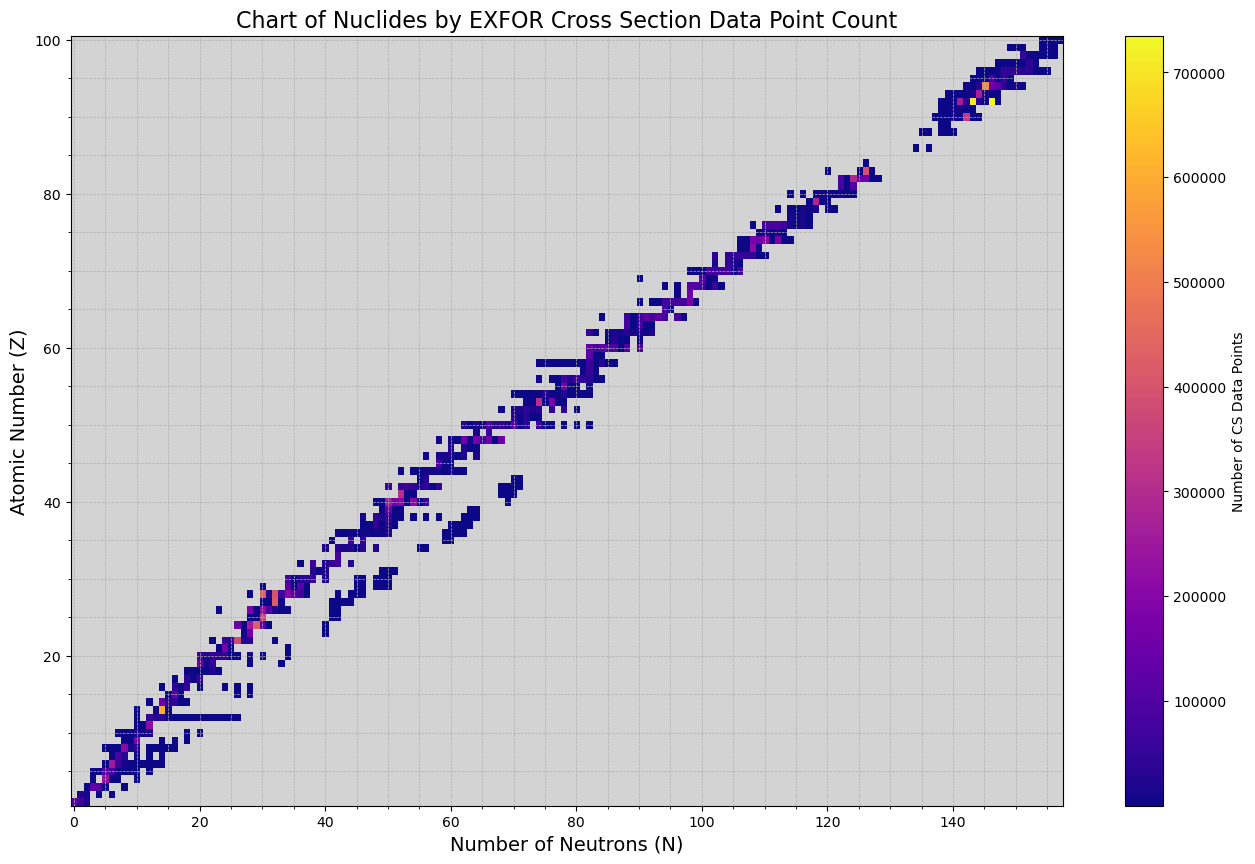

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- Plotting the Results ---

if 'numpy_results' in locals() and len(numpy_results) > 0:
    print("\nPreparing data for plotting...")
    
    protons = []
    neutrons = []
    counts = []

    for row in numpy_results:
        try:
            parts = row['isotope'].split('-')
            symbol = parts[0].upper()
            A = int(parts[1])
            Z = element_z_map[symbol]
            N = A - Z
            
            protons.append(Z)
            neutrons.append(N)
            counts.append(row['count'])
        except (ValueError, IndexError, KeyError):
            continue

    n_min, n_max = min(neutrons), max(neutrons)
    z_min, z_max = min(protons), max(protons)
    
    grid_rows = z_max - z_min + 1
    grid_cols = n_max - n_min + 1
    heatmap_data = np.full((grid_rows, grid_cols), np.nan)
    
    for Z, N, count in zip(protons, neutrons, counts):
        row_idx = Z - z_min
        col_idx = N - n_min
        heatmap_data[row_idx, col_idx] = (count)

    print("Generating plot...")
    
    plt.figure(figsize=(16, 10))
    cmap = plt.get_cmap('plasma')
    cmap.set_bad(color='lightgray')

    im = plt.imshow(
        heatmap_data, 
        cmap=cmap, 
        origin='lower',
        extent=[n_min - 0.5, n_max + 0.5, z_min - 0.5, z_max + 0.5],
        aspect='auto'
    )
    
    plt.xlabel('Number of Neutrons (N)', fontsize=14)
    plt.ylabel('Atomic Number (Z)', fontsize=14)
    plt.title('Chart of Nuclides by EXFOR Cross Section Data Point Count', fontsize=16)
    
    cbar = plt.colorbar(im, label='Number of CS Data Points')
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    
    plt.savefig('nuclide_heatmap.png', dpi=300, bbox_inches='tight')
    
    print("\nPlot has been generated and saved as 'nuclide_heatmap.png'")

else:
    print("\nThe 'numpy_results' array was not found or is empty. Please run the analysis cell first.")

In [12]:
# ...existing code...

if 'numpy_results' in locals() and len(numpy_results) > 0:
    # Filter out isotopes with zero data points (shouldn't be present, but just in case)
    nonzero_results = numpy_results[numpy_results['count'] > 0]
    
    # Top 10 isotopes with the most data
    print("\nTop 10 isotopes with the most cross section data points:")
    for iso, count in nonzero_results[:10]:
        print(f"{iso}: {count}")

    # Bottom 10 isotopes with the least (but non-zero) data
    print("\n10 isotopes with the least (but non-zero) cross section data points:")
    for iso, count in nonzero_results[-10:][::-1]:
        print(f"{iso}: {count}")
else:
    print("\nThe 'numpy_results' array was not found or is empty. Please run the analysis cell first.")


Top 10 isotopes with the most cross section data points:
U-238: 735063
U-235: 710127
AL-27: 599035
PU-239: 535731
CR-53: 438108
NI-58: 430982
CO-59: 424239
NI-60: 397211
BI-209: 393368
TI-48: 371986

10 isotopes with the least (but non-zero) cross section data points:
CU-59: 1
RA-227: 1
W-188: 1
AL-28: 2
CU-79: 2
DY-159: 2
ZR-89: 2
C-20: 3
CR-55: 3
F-27: 3
